<a href="https://colab.research.google.com/github/Ace1811/DIP---Lung-Nodules/blob/master/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%94%D0%B8%D0%B3%D0%B8%D1%82%D0%B0%D0%BB%D0%BD%D0%BE_%D0%9F%D1%80%D0%BE%D1%86%D0%B5%D1%81%D0%B8%D1%80%D0%B0%D1%9A%D0%B5_%D0%A1%D0%BB%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Looking into the data:

In [ ]:
from __future__ import print_function, division
import numpy as np
import csv
from glob import glob
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.color import label2rgb
%matplotlib inline

In [ ]:
import h5py
with h5py.File('/content/drive/MyDrive/Fakultet - Main/Semestri/Semestar 6 - Leten /4. Digitalno procesiranje na Slika/PROJECT/Data /all_patches.hdf5', 'r') as luna_h5:
    all_slices = luna_h5['ct_slices'][:]
    all_classes = luna_h5['slice_class'][:]
    print('data', all_slices.shape, 'classes', all_classes.shape)



data (6691, 64, 64) classes (6691, 1)


In [ ]:
type(all_classes)



numpy.ndarray

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


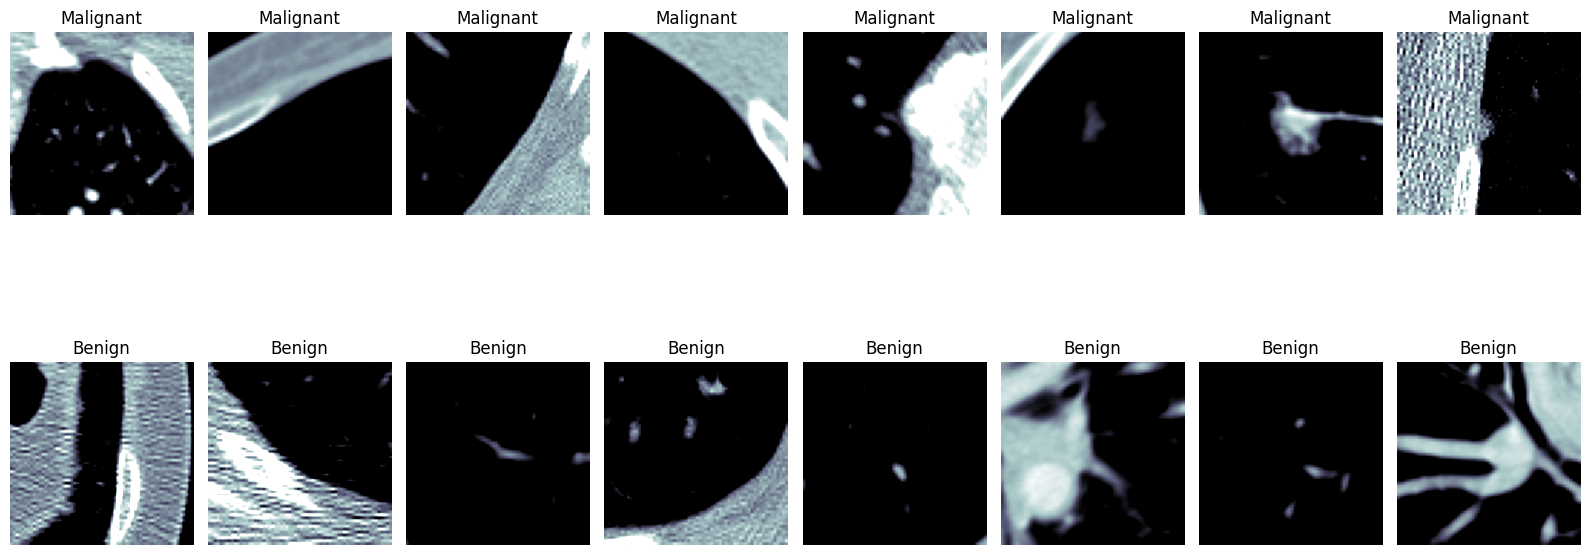

In [ ]:
#2
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt


# Set up plotting parameters
plt_args = dict(cmap='bone', vmin=-600, vmax=300)
n_samples = 8  # Number of samples to visualize for each class

# Select indices of malignant and benign slices
malignant_indices = np.random.choice(np.where(all_classes > 0.5)[0], size=n_samples)
benign_indices = np.random.choice(np.where(all_classes < 0.5)[0], size=n_samples)

# Create subplots for malignant and benign slices
fig, axs = plt.subplots(2, n_samples, figsize=(16, 8))

# Plot malignant slices
for i, idx in enumerate(malignant_indices):
    ax = axs[0, i]
    ax.imshow(all_slices[idx], **plt_args)
    ax.set_title('Malignant')
    ax.axis('off')

# Plot benign slices
for i, idx in enumerate(benign_indices):
    ax = axs[1, i]
    ax.imshow(all_slices[idx], **plt_args)
    ax.set_title('Benign')
    ax.axis('off')

plt.tight_layout()
plt.show()


# MODEL NO.1
#2 Library Imports

In [ ]:
#imports
import pandas as pd
import tensorflow as tf
#from keras_preprocessing.image.image_data_generator import ImageDataGenerator
from tensorflow.keras import Model,Sequential
from tensorflow.keras import layers
from keras import models
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import os
import cv2
import shutil

#Explanation about the code below --> 3

1.f = h5py.File('/content/drive/MyDrive/Fakultet - Main/Semestri/Semestar 6 - Leten /4. Digitalno procesiranje na Slika/PROJECT/Data /all_patches.hdf5','r')


This line opens an HDF5 file named all_patches.hdf5 located at the specified file path in read-only mode ('r').
h5py.File() is a function provided by the h5py library, which is a Python interface to the HDF5 binary data format. It is used to open HDF5 files.
The file path provided is a string that specifies the location of the HDF5 file on the file system.



2. print(list(f.keys()))

f.keys() returns a list-like object containing the keys (names) of datasets and groups in the HDF5 file.
list() is used to convert the returned keys object into a list for easier viewing.


3. ct_slices = f['ct_slices']
slice_class = f['slice_class']


These lines convert the retrieved features + Class (ct_slices and slice_class) from HDF5 format into NumPy arrays.
np.array() is a function provided by the NumPy library that converts input data (in this case, HDF5 datasets) into NumPy arrays.
After conversion, the datasets are assigned back to the same variables (ct_slices and slice_class) as NumPy arrays.


 **We have 6691 samples with 64x64 pixels
and we have 6691 samples with 1 dimension for 2 classes Benign or Malignant **bold text****

In [ ]:
#3
import h5py

f = h5py.File('/content/drive/MyDrive/Fakultet - Main/Semestri/Semestar 6 - Leten /4. Digitalno procesiranje na Slika/PROJECT/Data /all_patches.hdf5','r')
print(list(f.keys()))
ct_slices = f['ct_slices']
slice_class = f['slice_class']
ct_slices = np.array(ct_slices)
slice_class = np.array(slice_class)
print(ct_slices.shape)
print(slice_class.shape)
print(ct_slices[1].min())

['ct_slices', 'slice_class']
(6691, 64, 64)
(6691, 1)
-1024.0


#Explanation about the code below --> 4

1. np.clip --> we clip for a minimum of -1000 and maximum of 320

Visualization: By clipping the values to a specific range, you can ensure that the displayed image has a better contrast and is visually interpretable. For example, if you're displaying the image in grayscale, clipping the values to a range like -1000 to 320 ensures that the displayed image uses the full range of available colors, making it easier to distinguish between different tissues and structures.


This is done to limit the intensity values within a certain range for better visualization and analysis.



In [ ]:
ct_slices

320.0
-1000.0


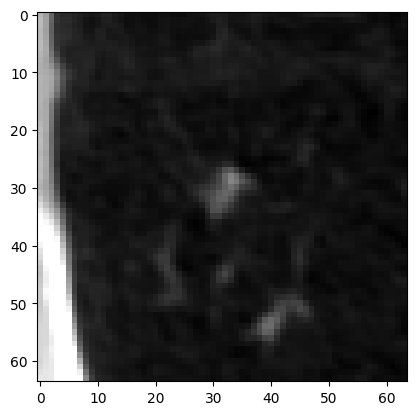

In [ ]:
#4
import pylab
ct_slices = np.clip(ct_slices, -1000,320)
print(ct_slices.max())
print(ct_slices.min())

pylab.imshow(ct_slices[308], cmap=pylab.cm.gray)
pylab.show()

#Explanation about the code below --> 5

Data Preprocessing: The CT slices data is reshaped to have a shape of (6691, 64, 64, 1) to fit the input shape expected by the model. Additionally, the train_test_split function from sklearn.model_selection is used to split the data into training and testing sets.


66% Train --> 33% Test size

We are turning the class (Y) into categorical

keras.utils.to_categorical(y_train, num_classes=2): This function, to_categorical, is used to convert an array of class labels (usually integers) into a binary class matrix. It essentially one-hot encodes the class labels. In other words, it converts each class label into a binary vector where only one element is 1 (indicating the class) and the rest are 0s. The y_train array contains the class labels for the training data. The argument num_classes=2 specifies the total number of classes in your classification problem, which in this case is 2.

y_train = keras.utils.to_categorical(y_train, num_classes=2): This line applies the to_categorical function to the training labels (y_train). After this line executes, y_train will be a binary class matrix where each row corresponds to a sample in the training data, and each column represents a class. The element at position (i, j) will be 1 if the i-th sample belongs to class j, and 0 otherwise.

y_test = keras.utils.to_categorical(y_test, num_classes=2): This line performs the same operation as the previous one but for the test labels (y_test). It converts the test labels into a binary class matrix format.

In [ ]:
#5
from sklearn.model_selection import train_test_split
from tensorflow import keras

ct_slices = ct_slices.reshape(6691,64,64,1)
#slice_class = slice_class(6691,64,64,1)

X_train, X_test, y_train, y_test = train_test_split(ct_slices, slice_class, test_size=0.33, random_state=33)

y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)


print(X_train.shape)
print(y_train.shape)

(4482, 64, 64, 1)
(4482, 2)


#Explanation about the code below --> 6
#Build CNN with Keras

A convolutional neural network (CNN) model is defined using Sequential API from Keras. It consists of several convolutional layers (Conv2D), max-pooling layers (MaxPooling2D), and a dense layer (Dense). The model is compiled with a specified loss function, optimizer, and metrics.


**Activation Parameter** -->

The activation parameter specifies the activation function applied to the output of the convolution operation. Here, Rectified Linear Unit (ReLU) activation function ('relu') is used, which introduces non-linearity into the model.

**Padding** -->

The padding parameter determines how the input is padded during convolution to maintain spatial dimensions. In this case, 'same' padding is used, which pads the input so that the output has the same spatial dimensions as the input.

**Max pooling layers** -->

(MaxPooling2D) downsample the input representation by taking the maximum value from a window of size 2x2. It helps reduce computational complexity and control overfitting by reducing the number of parameters.

**Global average pooling** -->

 (GlobalAveragePooling2D) layer calculates the average value of each feature map across spatial dimensions (height and width). It reduces the spatial dimensions to 1x1, resulting in a fixed-size output regardless of input size.

**Flatten layer** -->

(Flatten) flattens the input into a 1D array, which is required before passing the data to the fully connected layers.


**Fully Connected Layer** -->

Dense layer (Dense) is a fully connected layer where each neuron is connected to every neuron in the previous layer. The 2 specifies the output dimensionality, indicating that the model will output a probability distribution over two classes.


**loss function** -->

loss='categorical_crossentropy' specifies the loss function to be used during training. Categorical cross-entropy is commonly used for multi-class classification problems.


**activation** --> Softmax


The activation='softmax' parameter specifies that the softmax activation function will be applied to the output of this layer. Softmax converts the raw output values into probabilities, ensuring that the output vector sums to 1 and each element represents the probability of a particular class.



**optimizer** --> Adam

dam' optimizer (optimizer='Adam') is used to update the weights of the network based on the calculated gradient. Adam is an adaptive learning rate optimization algorithm that combines the advantages of AdaGrad and RMSProp.





In [ ]:
#6 TUKA SUM
from keras.applications.resnet50 import ResNet50
#from keras.applications import MobileNetV2
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import backend as K
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import numpy as np
import skimage.transform
import keras


model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(64,64,1)))


model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))


model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(GlobalAveragePooling2D())
model.add(Flatten())


model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

history = model.fit(
        X_train,y_train,
        batch_size=10,
        epochs=10,
        validation_data=(X_test, y_test))


Epoch 1/10
449/449 [==============================] - 56s 123ms/step - loss: 1.0240 - accuracy: 0.5977 - val_loss: 0.6517 - val_accuracy: 0.6727
Epoch 2/10
449/449 [==============================] - 55s 122ms/step - loss: 0.6333 - accuracy: 0.6564 - val_loss: 0.6194 - val_accuracy: 0.6646
Epoch 3/10
449/449 [==============================] - 54s 120ms/step - loss: 0.6006 - accuracy: 0.6787 - val_loss: 0.5792 - val_accuracy: 0.7094
Epoch 4/10
449/449 [==============================] - 54s 119ms/step - loss: 0.5802 - accuracy: 0.6992 - val_loss: 0.5605 - val_accuracy: 0.7125
Epoch 5/10
449/449 [==============================] - 54s 120ms/step - loss: 0.5577 - accuracy: 0.7202 - val_loss: 0.5667 - val_accuracy: 0.6922
Epoch 6/10
449/449 [==============================] - 54s 120ms/step - loss: 0.5225 - accuracy: 0.7468 - val_loss: 0.5154 - val_accuracy: 0.7641
Epoch 7/10
449/449 [==============================] - 55s 123ms/step - loss: 0.4969 - accuracy: 0.7539 - val_loss: 0.5405 - val_ac

#Explanation about the code below --> 7

Summary of the parameters and shape of the layers

In [ ]:
#7
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                   

#Explanation about the code below --> 8

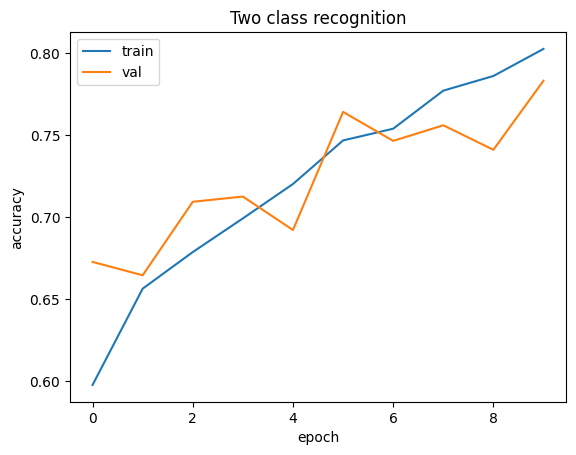

In [ ]:
#8
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Two class recognition')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


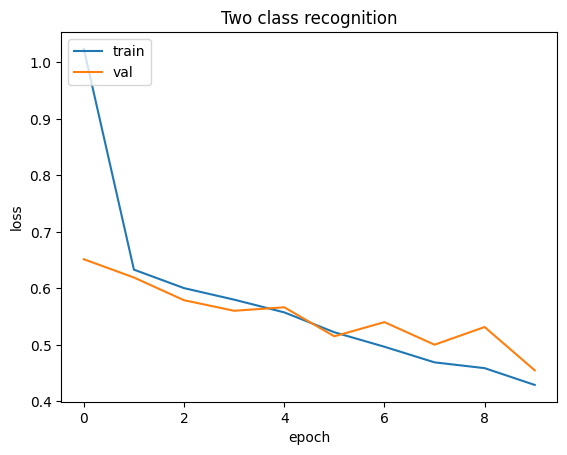

In [ ]:
#8
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Two class recognition')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#Explanation about the code below --> 9

CAM Generation Function: A function make_gradcam_heatmap is defined to generate Class Activation Maps (CAM) for a given image and model. CAM is a technique used to visualize the regions of an image that are important for the prediction made by the model.

In [ ]:
#9

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

#Explanation about the code below --> 10


In [ ]:
#10
def normalization(image):
    return (image - image.min())/(image.max() - image.min())

def gray_to_redblue(image):
    R,G,B = image[:,:,0], image[:,:,1], image[:,:,2]
    #grey = sum(pixel) // len(pixel)
    redvalue = 1 - R  # "darkness"
    bluevalue = B  # "brightness"
    image[:,:,0] = B
    image[:,:,1] = 0
    image[:,:,2] = 1-R
    return image# + alpha

#Explanation about the code below --> 11
Normalization and Visualization of CAM: The CAM is generated for a specific image (ct_slices[40]) and visualized along with the original image and heatmap using pylab.imshow().

1/1 [==============================] - 0s 29ms/step


(32, 32)
(64, 64, 3)
(64, 64, 3)


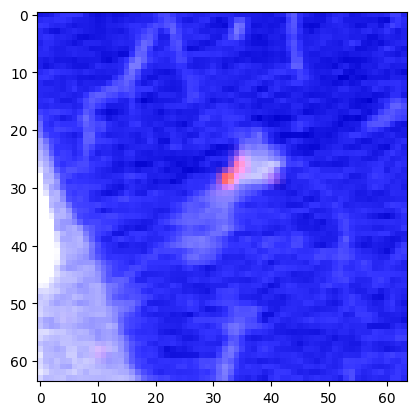

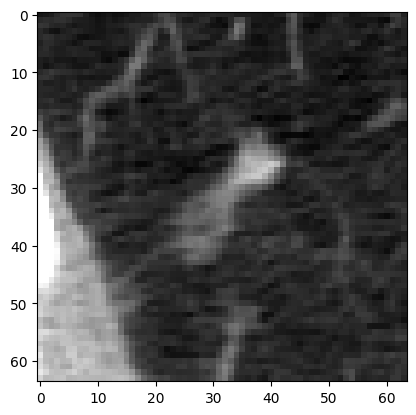

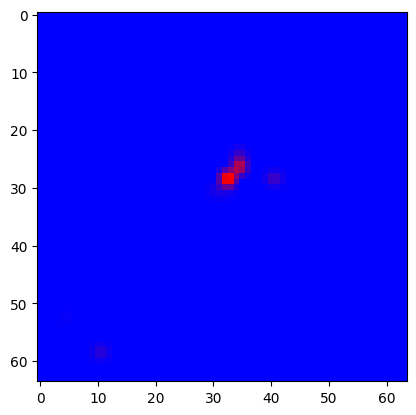

In [ ]:
#11
import cv2
from PIL import Image
from sklearn import preprocessing
import tensorflow as tf

def generate_CAM(image,layer):
    img_array = np.reshape(image,(1,64,64,1))
    preds = model.predict(img_array)
    H5py_cam = make_gradcam_heatmap(img_array,model,layer)
    print(H5py_cam.shape)
    heatmap = cv2.resize(H5py_cam,(img_array.shape[1],img_array.shape[2]))
    img_map = np.reshape(img_array,(64,64))
    heatmap = normalization(heatmap)
    img_map = normalization(img_map)
    heatmap = cv2.cvtColor(heatmap,cv2.COLOR_GRAY2RGB)
    img_map = cv2.cvtColor(img_map,cv2.COLOR_GRAY2RGB)
    heatmap = gray_to_redblue(heatmap)
    #heatmap = cv2.cvtColor(heatmap,cv2.COLOR_GRAY2RGB)
    print(heatmap.shape)
    print(img_map.shape)
    combination = heatmap * 0.8 + img_map * 1

    plt.imshow(combination)
    plt.show()

    pylab.imshow(img_map, cmap=pylab.cm.gray)
    pylab.show()
    pylab.imshow(heatmap, cmap=pylab.cm.jet)
    pylab.show()

generate_CAM(ct_slices[40],'max_pooling2d')


##Explanation about the code below --> 12



In [ ]:
####

In [ ]:
#12
from sklearn.metrics import classification_report
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))

70/70 [==============================] - 7s 95ms/step

              precision    recall  f1-score   support

           0       0.77      0.94      0.84      1375
           1       0.84      0.53      0.65       834

    accuracy                           0.78      2209
   macro avg       0.80      0.73      0.75      2209
weighted avg       0.79      0.78      0.77      2209



#Explanation about the code below --> 13



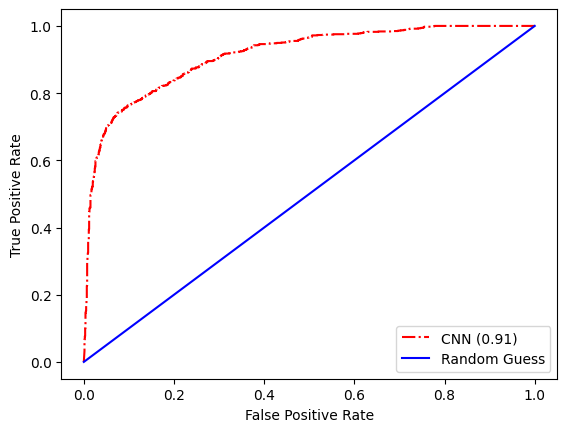

In [ ]:
#13
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()

#Model #2

In [ ]:
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',input_shape=(64,64,1)))


model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model2.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')) #added

model2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')) #added
model2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same')) #added




model2.add(MaxPooling2D(pool_size=(2, 2)))



model2.add(GlobalAveragePooling2D())
model2.add(Flatten())


model2.add(Dense(2, activation='softmax'))

model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

history2 = model2.fit(
        X_train,y_train,
        batch_size=5,
        epochs=5,
        validation_data=(X_test, y_test))

Epoch 1/5
897/897 [==============================] - 92s 101ms/step - loss: 0.7376 - accuracy: 0.6185 - val_loss: 0.6541 - val_accuracy: 0.6351
Epoch 2/5
897/897 [==============================] - 105s 117ms/step - loss: 0.6552 - accuracy: 0.6292 - val_loss: 0.6334 - val_accuracy: 0.6686
Epoch 3/5
897/897 [==============================] - 90s 100ms/step - loss: 0.6503 - accuracy: 0.6412 - val_loss: 0.6490 - val_accuracy: 0.6333
Epoch 4/5
897/897 [==============================] - 89s 99ms/step - loss: 0.6396 - accuracy: 0.6481 - val_loss: 0.7653 - val_accuracy: 0.6469
Epoch 5/5
897/897 [==============================] - 99s 111ms/step - loss: 0.6425 - accuracy: 0.6419 - val_loss: 0.6250 - val_accuracy: 0.6541


In [ ]:
#7
model2.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 conv2d_54 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_56 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 32)        9248      
                                                      

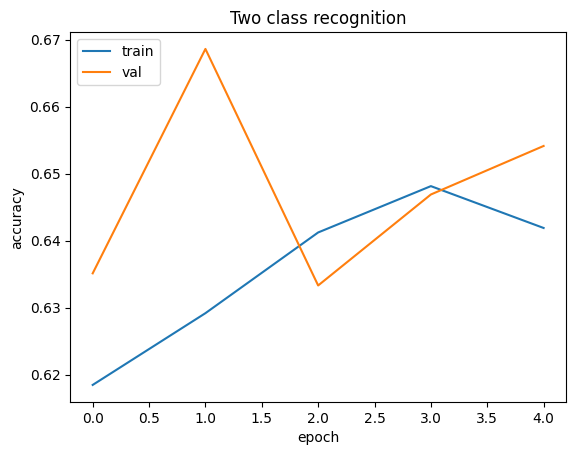

In [ ]:
#8
from matplotlib import pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Two class recognition')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


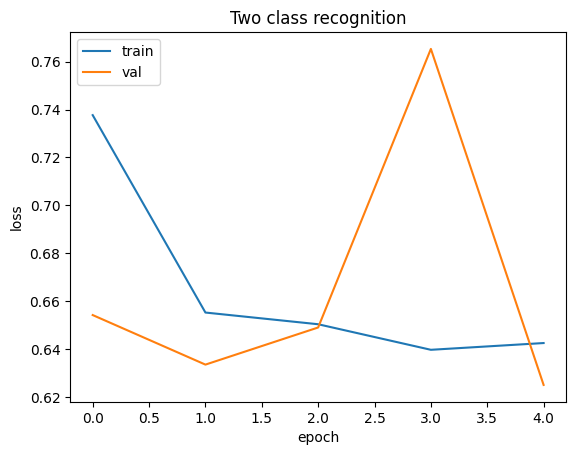

In [ ]:
#8
from matplotlib import pyplot as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Two class recognition')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


#Data was taken from Kaggle
#https://www.kaggle.com/datasets/kmader/lungnodemalignancy/data


#Model number 3 LETS GO

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
#6 TUKA SUM
from keras.applications.resnet50 import ResNet50
#from keras.applications import MobileNetV2
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Input
from keras import backend as K
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
import torch.nn.functional as F
import numpy as np
import skimage.transform
import keras

In [ ]:
def create_model(input_shape):
    model = models.Sequential()
    model.add(CosSimConv2D(units=32, input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [ ]:
model = create_model(input_shape)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(validation_images, validation_labels))


In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_accuracy)


Epoch 1/10
23/23 [==============================] - 609s 26s/step - loss: 5.9282 - accuracy: 0.5901 - val_loss: 0.6663 - val_accuracy: 0.6225
Epoch 2/10
23/23 [==============================] - 529s 23s/step - loss: 0.6641 - accuracy: 0.6225 - val_loss: 0.6634 - val_accuracy: 0.6225
Epoch 3/10
23/23 [==============================] - 533s 23s/step - loss: 0.6648 - accuracy: 0.6151 - val_loss: 0.6631 - val_accuracy: 0.6225
Epoch 4/10
23/23 [==============================] - 508s 22s/step - loss: 0.6643 - accuracy: 0.6225 - val_loss: 0.6629 - val_accuracy: 0.6225
Epoch 5/10
23/23 [==============================] - 528s 23s/step - loss: 0.6636 - accuracy: 0.6225 - val_loss: 0.6637 - val_accuracy: 0.6225
Epoch 6/10
23/23 [==============================] - 526s 23s/step - loss: 0.6634 - accuracy: 0.6225 - val_loss: 0.6621 - val_accuracy: 0.6225
Epoch 7/10
23/23 [==============================] - 499s 22s/step - loss: 0.6629 - accuracy: 0.6225 - val_loss: 0.6618 - val_accuracy: 0.6225
Epoch 

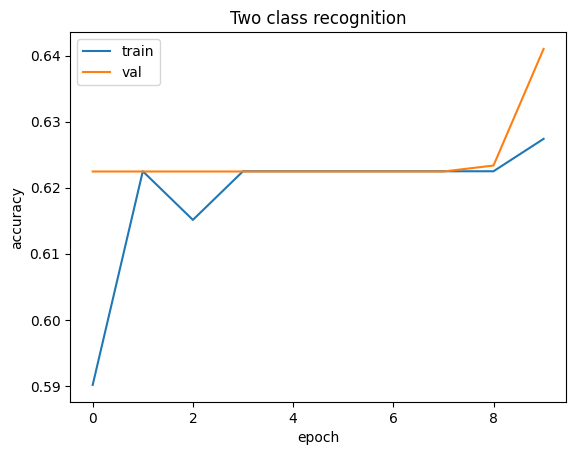

70/70 [==============================] - 57s 806ms/step

              precision    recall  f1-score   support

           0       0.64      0.96      0.77      1375
           1       0.63      0.12      0.20       834

    accuracy                           0.64      2209
   macro avg       0.64      0.54      0.48      2209
weighted avg       0.64      0.64      0.55      2209



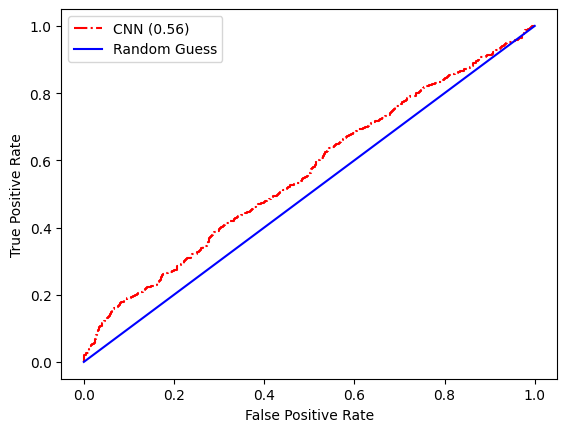

In [ ]:
## Changed size of filter
model = Sequential()


model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same',input_shape=(64,64,1)))
# model.add(Dropout(0.2))
#model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(MyCustomLayer(32,use_bias = False))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# # model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'))
# # model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))


# model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
# model.add(Dense(64, activation = 'relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
#kernel_regularizer=l2(1e-2)
# model.fit(x_train, y_train,
#           batch_size=64,
#           epochs=10,
#           verbose=1,
#           validation_data=(x_test, y_test))
history = model.fit(
        X_train,y_train,
        batch_size=200,
        epochs=10,
        validation_data=(X_test, y_test))

model.summary()

from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Two class recognition')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from sklearn.metrics import classification_report
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(np.argmax(y_test,1),
                      y_pred))

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()